In [42]:
# additional dependencies
# %pip install imblearn
# %pip install dython
# %pip install --upgrade numpy dython
# %pip install pgeocode
# %pip install pandarallel
# %pip install ipywidgets
# %pip install joblib

# Small Business Loan Approvals - US Analysis Context

**Problem**
<br>{insert stat}% of new businesses and aspiring startup founders are plagued with funding issues owing to a lack of transparency and resources regarding funding.

https://www.channelnewsasia.com/business/singapore-startups-difficulties-fundraising-silicon-valley-bank-signature-bank-collapse-3343421

**Approach**
<br>As part of our efforts to provide an analytical solution for the startup ecosystem in SG, our data analysis and modelling methodology here uses historic US Small Business Association data as a relevant proof of concept demonstration of how similar banking and corporate administrative data in a Singapore context could also be employed to shed light on the funding process for both startups and funders, increasing inclusivity and accessibility for all ecosystem players. Additionally, the insights help improve funding efficiency by exploring loan default rates, increasing economic sustainability.

**Target**
We seek to develop a predictive model. The model that will classify a given loan application and output its probabilities as a proxy to represent a given loan application's chance (%) of approval. 


**Data** <br>
| Variable Name        | Data Type  | Description                                                   |
|----------------------|------------|---------------------------------------------------------------|
| `LoanNr_ChkDgt`      | Text       | Identifier – Primary key                                      |
| `Name`               | Text       | Borrower name                                                 |
| `City`               | Text       | Borrower city                                                 |
| `State`              | Text       | Borrower state                                                |
| `Zip`                | Text       | Borrower zip code                                             |
| `Bank`               | Text       | Bank name                                                     |
| `BankState`          | Text       | Bank state                                                    |
| `NAICS`              | Text       | North American industry classification system code            |
| `ApprovalDate`       | Date/Time  | Date SBA commitment issued                                    |
| `ApprovalFY`         | Text       | Fiscal year of commitment                                     |
| `Term`               | Number     | Loan term in months                                           |
| `NoEmp`              | Number     | Number of business employees                                  |
| `NewExist`           | Text       | 1 = Existing business, 2 = New business                       |
| `CreateJob`          | Number     | Number of jobs created                                        |
| `RetainedJob`        | Number     | Number of jobs retained                                       |
| `FranchiseCode`      | Text       | Franchise code, (00000 or 00001) = No franchise               |
| `UrbanRural`         | Text       | 1 = Urban, 2 = rural, 0 = undefined                           |
| `RevLineCr`          | Text       | Revolving line of credit: Y = Yes, N = No                     |
| `LowDoc`             | Text       | LowDoc Loan Program: Y = Yes, N = No                          |
| `ChgOffDate`         | Date/Time  | The date when a loan is declared to be in default             |
| `DisbursementDate`   | Date/Time  | Disbursement date (typically after approval date)                                             |
| `DisbursementGross`  | Currency   | Amount disbursed                                              |
| `BalanceGross`       | Currency   | Gross amount outstanding                                      |
| `MIS_Status`         | Text       | Loan status: charged off = CHGOFF, Paid in full = PIF         |
| `ChgOffPrinGr`       | Currency   | Charged-off amount                                            |
| `GrAppv`             | Currency   | Gross amount of loan approved by bank                         |
| `SBA_Appv`           | Currency   | SBA’s guaranteed amount of approved loan                      |


In [35]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
import shap
shap.initjs()
import dython
from dython.nominal import associations
import joblib

%config IPCompleter.greedy=True # enable ipython code autocomplete function
from IPython.display import display, Markdown # enable display of all columns

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format # set number of decimal places to 3dp for pandas presentation

## Data Preprocessing

In [3]:
# Load and preview dataset
df = pd.read_csv('SBAnational.csv', engine='pyarrow')
display(df.info())
display(df)

# load mappings
industry_mapping = {
    '11': 'Ag/For/Fish/Hunt',
    '21': 'Min/Quar/Oil_Gas_ext',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale_trade',
    '44': 'Retail_trade',
    '45': 'Retail_trade',
    '48': 'Trans/Ware',
    '49': 'Trans/Ware',
    '51': 'Information',
    '52': 'Finance/Insurance',
    '53': 'RE/Rental/Lease',
    '54': 'Prof/Science/Tech',
    '55': 'Mgmt_comp',
    '56': 'Admin_sup/Waste_Mgmt_Rem',
    '61': 'Educational',
    '62': 'Healthcare/Social_assist',
    '71': 'Arts/Entertain/Rec',
    '72': 'Accom/Food_serv',
    '81': 'Other_no_pub',
    '92': 'Public_Admin'
}

state_mapping = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands': 'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

None

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2.00,0,0,1,0,N,Y,None,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,60,2,2.00,0,0,1,0,N,Y,None,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,7,1.00,0,0,1,0,N,N,None,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,60,2,1.00,0,0,1,0,N,Y,None,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,240,14,1.00,7,7,1,0,N,N,None,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,27-Feb-97,1997,60,6,1.00,0,0,1,0,0,N,None,30-Sep-97,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00"
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,27-Feb-97,1997,60,6,1.00,0,0,1,0,Y,N,None,31-Oct-97,"$85,000.00",$0.00,P I F,$0.00,"$85,000.00","$42,500.00"
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,27-Feb-97,1997,108,26,1.00,0,0,1,0,N,N,None,30-Sep-97,"$300,000.00",$0.00,P I F,$0.00,"$300,000.00","$225,000.00"
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,27-Feb-97,1997,60,6,1.00,0,0,1,0,N,Y,8-Mar-00,31-Mar-97,"$75,000.00",$0.00,CHGOFF,"$46,383.00","$75,000.00","$60,000.00"


#### General Preprocessing: Inspect data integrity, standardise data type and handle missing values

In [4]:
def check_dtypes(df, col_name):
    column_datatypes = pd.api.types.infer_dtype(df[col_name])
    return column_datatypes

def get_data_overview(df, sort_dtypes=True):
    df_length = len(df)
    data_overview = {}
    for col in df.columns:
        dtype = check_dtypes(df, col)
        n_null = df[col].isna().sum()
        # if dtype in ['object', 'category']:
        value_counts = df[col].value_counts(normalize=True) * 100
        max_class_pct = value_counts.max()
        min_class_pct = value_counts.min()
        data_overview[col] = {'infer_dtype': dtype,
                              'n_null': n_null,
                              'null%': n_null / df_length * 100,
                              'n_unique': len(value_counts.keys()),
                              'max_class_repr%': max_class_pct,
                              'min_class_repr%': min_class_pct}    
    if sort_dtypes == True:
        return pd.DataFrame(data_overview).T.sort_values(by='infer_dtype')
    else:
        return pd.DataFrame(data_overview).T
    
get_data_overview(df, sort_dtypes=False)

,infer_dtype,n_null,null%,n_unique,max_class_repr%,min_class_repr%
LoanNr_ChkDgt,integer,0,0.00,899164,0.00,0.00
Name,string,14,0.00,779583,0.14,0.00
City,string,30,0.00,32581,1.29,0.00
State,string,14,0.00,51,14.53,0.18
Zip,integer,0,0.00,33611,0.10,0.00
Bank,string,1559,0.17,5802,9.68,0.00
BankState,string,1566,0.17,56,13.16,0.00
NAICS,integer,0,0.00,1312,22.46,0.00
ApprovalDate,string,0,0.00,9859,0.13,0.00
ApprovalFY,string,0,0.00,52,8.62,0.00


In [46]:
# Drop duplicates and keep only first record
df = df.drop_duplicates(keep='first')

# Drop rows containing missing values for `MIS_Status` 
# as they will not be able to help us gauge loan default rate.
df = df[df['MIS_Status'].notna()]

# Check our loan default target
df['MIS_Status'].value_counts()

MIS_Status
P I F     739609
CHGOFF    157558
Name: count, dtype: int64

In [47]:
CHGOFF_df = df[df['MIS_Status']=='CHGOFF']
PIF_df = df[df['MIS_Status']=='P I F']

# Check the proportion of null values for both 'CHGOFF' and 'P I F' loans before we remove any nulls
# as we want to preserve as much information especially for 'CHGOFF' being the minority class
CHGOFF_df_nullpct = CHGOFF_df.isna().sum() / len(CHGOFF_df)
PIF_df_nullpct = PIF_df.isna().sum() / len(PIF_df)

print('Null values only account for:')
print(f"{CHGOFF_df_nullpct.sum(): .3f} % of the 'Charged Off' class.")
print(f"{PIF_df_nullpct.sum(): .3f} % of the 'Paid In Full' class.")

Null values only account for:
 0.010 % of the 'Charged Off' class.
 1.008 % of the 'Paid In Full' class.


In [48]:
nullcols_excl_chgoffdate = [col for col in df.columns if 'ChgOffDate' not in col]

# drop rows containing nulls where MIS_Status classes with minimal loss of data
# we exclude `ChgOffDate` for now since it's more than >50% of the dataset, and requires further exploration.
cleaned_df = df.dropna(subset=nullcols_excl_chgoffdate, axis=0)

Datatype conversion and standardisation

In [49]:
def remove_chars(series):
    try:
        return series.str.replace('[\$,]', '', regex=True)
    except AttributeError as e:
        # logging.exception(e)
        return series    

In [50]:
# 1. Convert to string/obj
for i in ['Zip', 'NAICS','FranchiseCode', 'MIS_Status', 'UrbanRural']:
    cleaned_df[i] = cleaned_df[i].astype('O')

# 2. Convert date/time variables and create `DisbursementFY` 
for i in ['ApprovalDate', 'ChgOffDate', 'DisbursementDate']:
    cleaned_df[i] = pd.to_datetime(cleaned_df[i], errors='coerce')

cleaned_df['DisbursementFY'] = cleaned_df['DisbursementDate'].dt.year

# 3. Convert numerical variables such as balances to int/float dtypes
for i in ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']:
    # strip characters then convert to integer
    cleaned_df[i] = remove_chars(cleaned_df[i]).astype('float32')

# 4. Replace missing State details using Zipcode info.
nomi = pgeocode.Nominatim('us')
def get_state_from_zip(zip_code):
    if pd.isna(zip_code):
        return None
    location = nomi.query_postal_code(zip_code)
    return location.state_name if location is not None else None

# Apply the function only to rows where State is missing
cleaned_df['State'] = cleaned_df.apply(lambda row: get_state_from_zip(row['Zip']) if pd.isna(row['State']) else row['State'], axis=1)
cleaned_df['BankState'] = cleaned_df.apply(lambda row: get_state_from_zip(row['Zip']) if pd.isna(row['BankState']) else row['BankState'], axis=1)

cleaned_df['State'] = cleaned_df['State'].replace(state_mapping)
cleaned_df['BankState'] = cleaned_df['BankState'].replace(state_mapping)

# Verify the results
print('UNIQUE STATES:', cleaned_df['State'].unique())
print(cleaned_df['State'].isnull().sum(), 'missing values')
print()
print('UNIQUE BANKSTATES:', cleaned_df['BankState'].unique())
print(cleaned_df['BankState'].isnull().sum(), 'missing values')

C:\Users\valer\AppData\Local\Temp\ipykernel_8472\1977675038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[i] = cleaned_df[i].astype('O')
C:\Users\valer\AppData\Local\Temp\ipykernel_8472\1977675038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[i] = cleaned_df[i].astype('O')
C:\Users\valer\AppData\Local\Temp\ipykernel_8472\1977675038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

UNIQUE STATES: ['IN' 'OK' 'FL' 'CT' 'NJ' 'NC' 'IL' 'RI' 'TX' 'VA' 'TN' 'AR' 'MN' 'MO'
 'MA' 'CA' 'SC' 'LA' 'IA' 'OH' 'KY' 'MS' 'NY' 'MD' 'PA' 'OR' 'ME' 'KS'
 'MI' 'AK' 'WA' 'CO' 'MT' 'WY' 'UT' 'NH' 'WV' 'ID' 'AZ' 'NV' 'WI' 'NM'
 'GA' 'ND' 'VT' 'AL' 'NE' 'SD' 'HI' 'DE' 'DC']
0 missing values

UNIQUE BANKSTATES: ['OH' 'IN' 'OK' 'FL' 'DE' 'SD' 'AL' 'CT' 'GA' 'OR' 'MN' 'RI' 'NC' 'TX'
 'MD' 'NY' 'TN' 'SC' 'MS' 'MA' 'LA' 'IA' 'VA' 'CA' 'IL' 'KY' 'PA' 'MO'
 'WA' 'MI' 'UT' 'KS' 'WV' 'WI' 'AZ' 'NJ' 'CO' 'ME' 'NH' 'AR' 'ND' 'MT'
 'ID' 'WY' 'NM' 'DC' 'NV' 'NE' 'PR' 'HI' 'VT' 'AK' 'GU' 'AN' 'EN' 'VI']
0 missing values


C:\Users\valer\AppData\Local\Temp\ipykernel_8472\1977675038.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['BankState'] = cleaned_df['BankState'].replace(state_mapping)


Standardise classes in binary variables:

Certain columns such as `NewExist`, `LowDoc` & `RevLineCr` are supposed to be binary. However they contain more than 2 classes each. It might be too ambiguous for us to self-classify and correct them, so given that they account for less than 1% of the dataset, we will remove them for now.

In [51]:
# `NewExist`: 1 = new business (<2years), 2 = existing business (>2 years)
display(cleaned_df['NewExist'].value_counts(normalize=True))

# `LowDoc`: 'Y' = Yes, 'N' = No
display(cleaned_df['LowDoc'].value_counts(normalize=True))

# `RevLineCr`: 'Y' = Yes, 'N' = No
display(cleaned_df['RevLineCr'].value_counts(normalize=True))

# Filter out other unspecified values
cleaned_df = cleaned_df[cleaned_df['NewExist'] >= 1]
cleaned_df = cleaned_df[(cleaned_df['LowDoc']=='Y') | (cleaned_df['LowDoc']=='N')]
cleaned_df = cleaned_df[(cleaned_df['RevLineCr']=='Y') | (cleaned_df['RevLineCr']=='N')]

# Rename `NewExist` to `NewBusiness` for clarity and convert to object
cleaned_df.rename(columns={'NewExist': 'NewBusiness'}, inplace=True)
cleaned_df['NewBusiness'] = cleaned_df['NewBusiness'].astype('O')

NewExist
1.00   0.72
2.00   0.28
0.00   0.00
Name: proportion, dtype: float64

LowDoc
N   0.87
Y   0.12
0   0.00
C   0.00
S   0.00
A   0.00
R   0.00
1   0.00
Name: proportion, dtype: float64

RevLineCr
N   0.47
0   0.29
Y   0.22
T   0.02
1   0.00
R   0.00
`   0.00
2   0.00
C   0.00
3   0.00
,   0.00
7   0.00
A   0.00
5   0.00
.   0.00
4   0.00
-   0.00
Q   0.00
Name: proportion, dtype: float64

Dropping the following columns:

- `LoanNr_ChkDgt`: This is simply administrative indexing and does not tell anything about a borrower.
- `Name`: Established names could increase lender confidence, but this will not be applicable to new businesses which we aim to service.
- `ChgOffDate`: This info will not be available at the time of loan application, and some records may be inaccurate, eg. some 'paid in full' rows stll contain a charged-off date.
- `City` & `Zip`: These contain too many unique values respective to our dataset. Using this may implicitly assume that a business's location (down to the zip code / city) influences their funding eligibility, which may introduce model bias.
- `Bank`: The Bank's name itself might not be representative. Perhaps finding information on their funding quantums and asset size would be more effective.

In [52]:
cleaned_df.drop(columns=['City', 'Zip', 'LoanNr_ChkDgt', 'Name', 'ChgOffDate', 'Bank'], axis=1, inplace=True)
cleaned_df.reset_index(drop=True, inplace=True)

#### Feature engineering

`NAISC`: 

Industry could be a significant differentiator between loans since CAPEX and OPEX would vary greatly across industries (eg. Airlines vs Advertising industry)

In [54]:
# Relevant industry details are found in the first 2 digits of the `NAICS` column.
cleaned_df['Industry'] = cleaned_df['NAICS'].astype(str).str[:2]

cleaned_df['Industry'].unique()

array(['45', '72', '62', '0', '33', '81', '23', '44', '42', '61', '53',
       '54', '51', '31', '52', '32', '56', '71', '48', '11', '92', '22',
       '49', '55', '21'], dtype=object)

In [55]:
# Remove invalid records where NAICS code is 0
cleaned_df = cleaned_df[cleaned_df['Industry'] != '0']

# Map NAICS codes to industry names
cleaned_df['Industry'] = cleaned_df['Industry'].map(industry_mapping)
cleaned_df.reset_index(drop=True, inplace=True)

`FranchiseCode` & `Default`

In [132]:
# `FranchiseCode`
cleaned_df.loc[(cleaned_df['FranchiseCode'] <= 1), 'IsFranchise'] = 0
cleaned_df.loc[(cleaned_df['FranchiseCode'] > 1), 'IsFranchise'] = 1
cleaned_df['IsFranchise'] = cleaned_df['IsFranchise'].astype('O')

# `Default`
cleaned_df['Default'] = cleaned_df['MIS_Status'].apply(lambda x: 0 if x=='P I F' else 1)
cleaned_df['Default'] = cleaned_df['Default'].astype('O')
display(cleaned_df['Default'].value_counts())

print('defaulted loans:', cleaned_df[cleaned_df['Default']==1]['MIS_Status'].unique())
print('non-defaulted loans:', cleaned_df[cleaned_df['Default']==0]['MIS_Status'].unique())

Default
0    358558
1     98382
Name: count, dtype: int64

defaulted loans: ['CHGOFF']
non-defaulted loans: ['P I F']


`DurationBefDisburse`: To highlight the time elapsed between approval and disbursement dates

`SameState`: We engineer this to explore if lenders and borrowers being out-of-state may impact any default choices from borrowers.

`Recession`: Macroeconomic time-based indicator to highlight if the the loan was requested during recessions, which may affect disbursement outcomes and defaults.

`SBA_pct_Appv`: Guarantor approvals would be an agreed percentage of the gross amount and not absolute dollar values. Hence, transforming as a percentage would be more accurate.

In [146]:
# `DurationBefDisburse`
cleaned_df['DurationBefDisburse'] = cleaned_df['DisbursementDate']- cleaned_df['ApprovalDate']

# SameState
cleaned_df['SameState'] = np.where(cleaned_df['State'] == cleaned_df['BankState'], 1, 0)
cleaned_df['SameState'] = cleaned_df['SameState'].astype('O')

# `Recession`
cleaned_df['Recession'] = np.where(
    ((2007 <= cleaned_df['DisbursementFY'])
     & (cleaned_df['DisbursementFY'] <= 2009)) |
                                     ((cleaned_df['DisbursementFY'] < 2007)
                                      & (cleaned_df['DisbursementFY'] + (cleaned_df['Term']/12) >= 2007)), 1, 0)
cleaned_df['Recession'] = cleaned_df['Recession'].astype('O')

# `SBA_pct_Appv`:
cleaned_df['SBA_pct_Appv'] = cleaned_df['SBA_Appv'] / cleaned_df['GrAppv']

cleaned_df.drop(columns=['NAICS', 'FranchiseCode', 'MIS_Status', 'SBA_Appv', 'DisbursementGross'], inplace=True)



## 2. Exploratory Data Analysis

Overview of all variables' distributions

KeyboardInterrupt: 

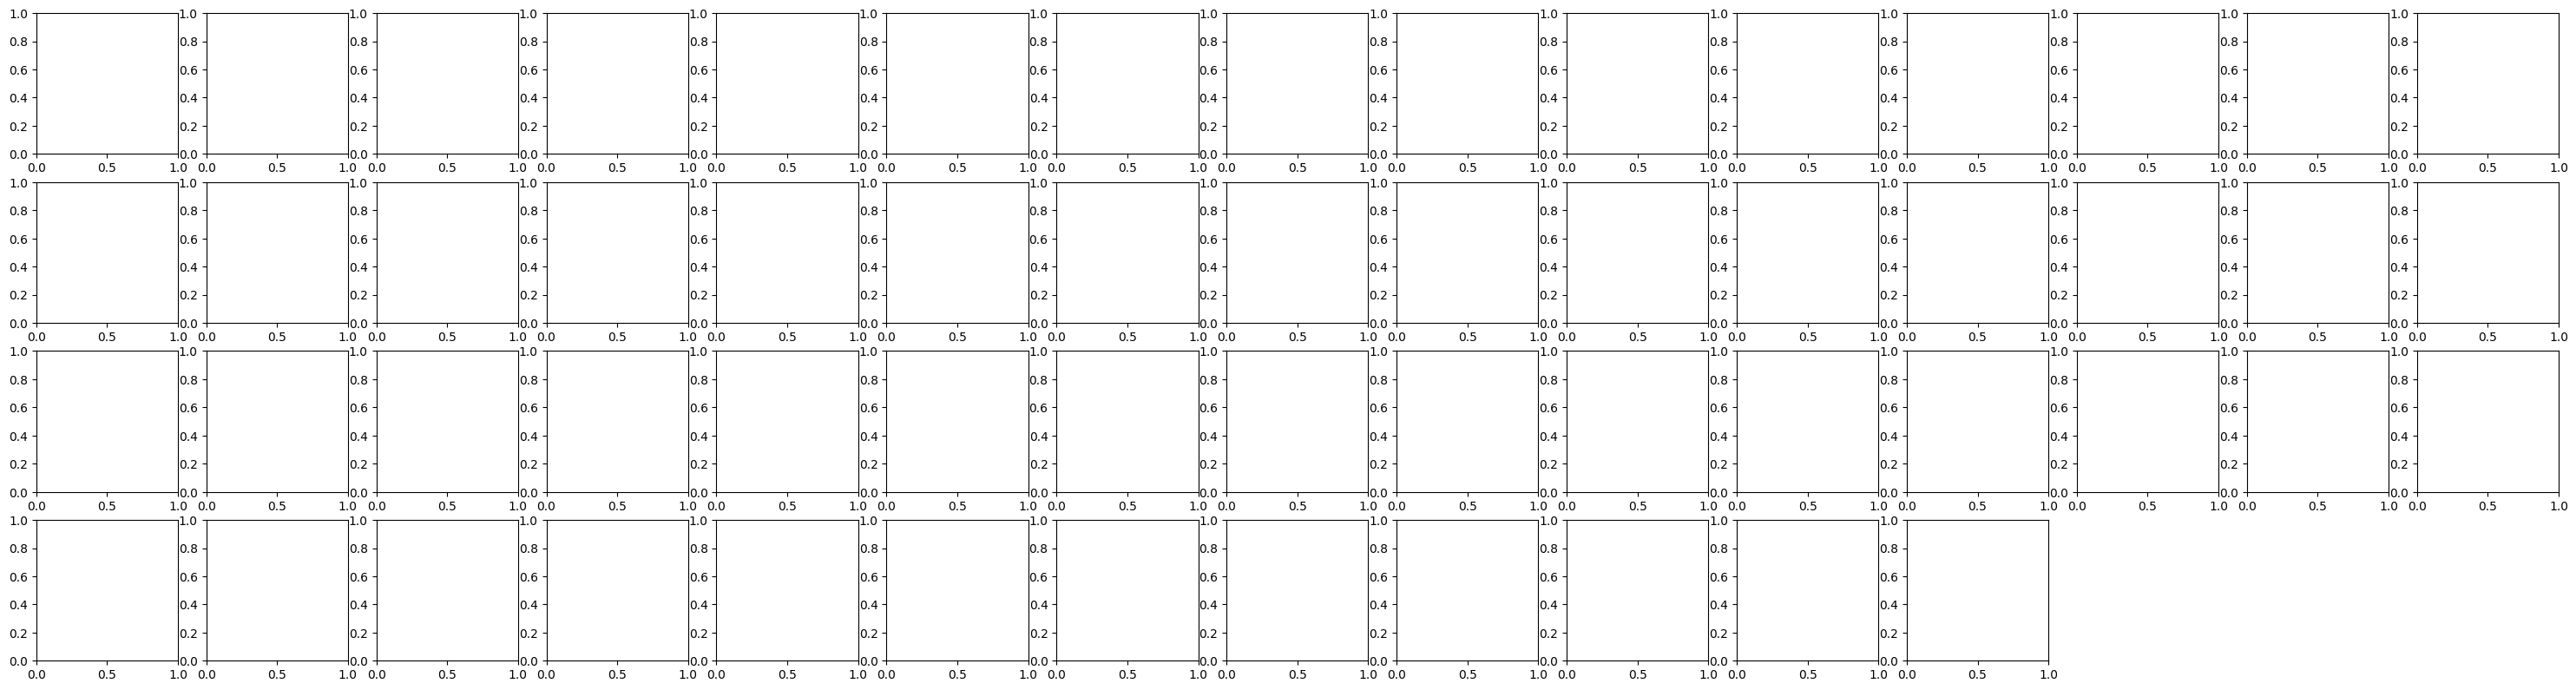

In [ ]:
sampled_df = cleaned_df.sample(frac=0.4)
sns.pairplot(sampled_df, 
             hue='MIS_Status',
             kind='scatter',
             diag_kind='kde')

Correlation Analysis of variables

In [ ]:
# Plot correlation matrix
sns.set_theme(rc={'figure.figsize':(12,5)})
sns.heatmap(cleaned_df.select_dtypes(exclude='string').corr(
    method='kendall', numeric_only=True), annot=True)

In [ ]:
associations(sampled_df, nom_nom_assoc='theil', figsize=(15, 15), compute_only=False)

### Analysis of Defaulted loans

In [ ]:
# Proportion of defaulted loans vs paid-in-full loans
cleaned_df['Default'].value_counts(normalize=True).plot(kind='bar',figsize=(7,5))

Default rates by State:

In [ ]:
cleaned_df['State'].unique()

In [ ]:
for state in cleaned_df['State'].unique():
    cleaned_df['Default'].value_counts().plot()

Default rates by Industry:

In [ ]:
for state in cleaned_df['State'].unique():
    cleaned_df['Default'].value_counts().plot()

Default rates by Bank:

In [ ]:
cleaned_df.groupby('Bank')

### Exploring employment-metrics ('NoEmp' ,'RetainedJob', 'CreateJob')

In [ ]:
headcount_vars = ['NoEmp' ,'RetainedJob', 'CreateJob']
cleaned_df[headcount_vars].plot(subplots=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each variable, apply log transformation, and plot
for idx, i in enumerate(headcount_vars):
    sns.histplot(cleaned_df[i], kde=True)
    plt.show()
    cleaned_df[i] = cleaned_df[i] + 1  # add 1 to prevent 'div by 0' error
    col_logtransform_name = f"{i}_log"
    cleaned_df[col_logtransform_name] = np.log(cleaned_df[i])
    
    # Plot the distribution on the respective subplot
    sns.histplot(cleaned_df[col_logtransform_name], kde=True, ax=axes[idx])
    axes[idx].set_title(f"Log-Transformed Distribution of {i}")

plt.tight_layout()
plt.show()

headcount_vars_includinglog = headcount_vars + [col for col in cleaned_df.columns if '_log' in col]
cleaned_df[headcount_vars_includinglog].describe()

## 3. Model Building

### Feature Importance

In [9]:
# Define features and target
numeric_features = ['NoEmp', 'Term', 'GrAppv']
categorical_features = ['State', 'Industry', 'NewBusiness']
target = 'Default'

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the full pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])

In [10]:
# train-test-splitting
model_sample = cleaned_df.sample(frac=0.1)
X = model_sample[numeric_features + categorical_features]
y = model_sample[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [37]:
#  Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'model__n_estimators': randint(100, 300),
    'model__max_depth': [10, 20, None],
    'model__max_features': ['sqrt', 'log2']
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(full_pipeline, 
                                   param_distributions=param_dist, 
                                   n_iter=3, 
                                   cv=3, 
                                   scoring='accuracy', 
                                   return_train_score=True, 
                                   random_state=13,
                                   verbose=2,
                                   n_jobs=-1)
random_search.fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['NoEmp',
                                                                                'Term',
                                                                                'GrAppv']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['State',
                                                                                'Industry',
                                                                                'NewBusiness'])])),
                                             ('model',
                                              RandomForestClassifier())]),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'model__max_depth': [10, 20, None],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C76D232710>},
                   random_state=13, return_train_score=True, scoring='accuracy',
                   verbose=2)

In [34]:
# Extract best parameters
best_params_random = random_search.best_params_
print("Best parameters found by RandomizedSearchCV:", best_params_random)

Best parameters found by RandomizedSearchCV: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__n_estimators': 286}


In [35]:
# Serialize the fitted model pipeline
joblib.dump(random_search.best_estimator_, 'best_model_pipeline_random.pkl')

['best_model_pipeline_random.pkl']

### Testing and evaluation of models

Evaluation Metrics

In [11]:
# Load the models
model_random = joblib.load('best_model_pipeline_random.pkl')

# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'f1_score': f1_score(y_test, y_pred)
    }
    return metrics

results_random = evaluate_model(model_random, X_test, y_test)

print("\nEvaluation results for RandomizedSearchCV:")
print(results_random)


Evaluation results for RandomizedSearchCV:
{'accuracy': 0.8399352212544317, 'confusion_matrix': array([[17606,   257],
       [ 3400,  1584]], dtype=int64), 'roc_auc': 0.9026272247871238, 'f1_score': 0.4641758241758242}
